In [1]:
using Plots
using NPZ
using Statistics
using ITensorMPS
using Serialization

### Explore phase diagram of XYZ model

The hamiltonian under consideration is **XYZ** model:

$$ H = \sum_{i} \left( J_x \sigma_i^x \sigma_{i+1}^x + J_y \sigma_i^y \sigma_{i+1}^y + J_z \sigma_i^z \sigma_{i+1}^z \right)$$

This model is **interacting** and **non-integrable**.

Th spin chain is exposed by dissppation $\sigma^-$ with rate $\gamma$.

We fix $J_x=0.9$, $J_z=1.0$ and vary $J_y$ and $\gamma$ to explore the phase diagram.


In [2]:
N = 8
Jx, Jz = 1.8, 2.0
n_traj = 100
folder = "XYZ_N$(N)_$(n_traj)traj_Jx$(Jx)_Jz$(Jz)"

gammas = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 50]
t_list_gamma = [
    range(0, 10000, length=100),
    range(0, 10000, length=100),
    range(0, 10000, length=100),
    range(0, 5000, length=100),
    range(0, 5000, length=100),
    range(0, 1000, length=100),
    range(0, 100, length=50),
    range(0, 100, length=50),
    range(0, 100, length=50),
    range(0, 100, length=50)
]

Jy_list = [-0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]


plt= plot(layout=(length(gammas), length(Jy_list)), size=(3000, 2000))
pltz =  plot(layout=(length(gammas), length(Jy_list)), size=(3000, 2000))

for (i, gamma) in enumerate(gammas)
    for (j, Jy) in enumerate(Jy_list)
        #check if the file exists
    
        if !isfile("data/$folder/Jy$(Jy)_gamma$(gamma)_t$(t_list_gamma[i][end]).npz")
            println("Jy = $Jy, gamma = $(gamma), t$(t_list_gamma[i][end])")
            println("data/$folder/Jy$(Jy)_gamma$(gamma)_t$(t_list_gamma[i][end]).npz")
            #fill the data
            ee_list_MC = zeros(n_traj, length(t_list_gamma[i]))
            z_list_MC = zeros(n_traj, length(t_list_gamma[i]))
        else 
            #read the data
            data = npzread("data/$folder/Jy$(Jy)_gamma$(gamma)_t$(t_list_gamma[i][end]).npz")
            ee_list_MC, z_list_MC = data["ee"], data["z"]
        end
       # println("Jy = $Jy, gamma = $(gamma), t$(t_list_gamma[i][end])")
       # print(length(mean(ee_list_MC, dims=1)[:]), " ", length( t_list_gamma[i]), '\n')
        plot!(plt[i, j], t_list_gamma[i], mean(ee_list_MC, dims=1)[:], title="Jy=$Jy, γ=$gamma", ylabel="S", xlabel="t", legend=false)
        plot!(pltz[i, j], t_list_gamma[i], mean(z_list_MC, dims=1)[:], title="Jy=$Jy, γ=$gamma", ylabel="magnetization Z", xlabel="t", legend=false)        
    end
end
# if !isdir("plots")
#     mkdir("plots")
# end
# savefig("plots/S_$Jx-$Jz.png")

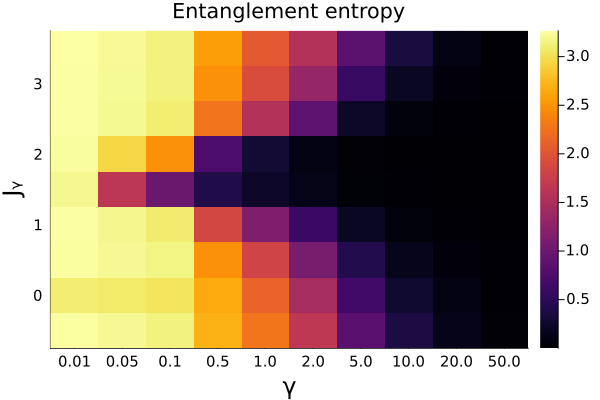

In [3]:
#find platuae values of S for each gamma and Jy
S_plateau = zeros(length(gammas), length(Jy_list))
Mz_plateau = zeros(length(gammas), length(Jy_list))
for (i, gamma) in enumerate(gammas)
    for (j, Jy) in enumerate(Jy_list)
        #data = npzread("data/$folder/Jy$(Jy)_Jx$(Jx)_Jz$(Jz)_gamma$(gamma)_t$(t_list_gamma[i][end]).npz")
        #println("gamma = $gamma, Jy = $Jy")
        data = npzread("data/$folder/Jy$(Jy)_gamma$(gamma)_t$(t_list_gamma[i][end]).npz")
        ee_list_MC, z_list_MC = data["ee"], data["z"]
        S_plateau[i, j] = mean(mean(ee_list_MC, dims=1)[end-10:end])
        #print("gamma = $gamma, Jy = $Jy, S = ", S_plateau[i, j], '\n')
        Mz_plateau[i, j] = mean(mean(z_list_MC, dims=1)[end-10:end])
    end
end

#make a heatmap of the plateau values
gammas_dummy = [i for i in 1:length(gammas)]
custom_gamma_labels = ["$gamma" for gamma in gammas]
heatmap_plot = heatmap(gammas_dummy, Jy_list, transpose(S_plateau), xlabel="γ", ylabel="Jᵧ",
        title="Entanglement entropy",
         xticks=(gammas_dummy, custom_gamma_labels), tickfontsize=10, 
         xlabelfontsize=16,      # Size of the x-axis label
    ylabelfontsize=16, )

if !isdir("plots")
    mkdir("plots")
end

display(heatmap_plot)
# savefig("plots/S_$(Jx)_$(Jz)_plateau.pdf")

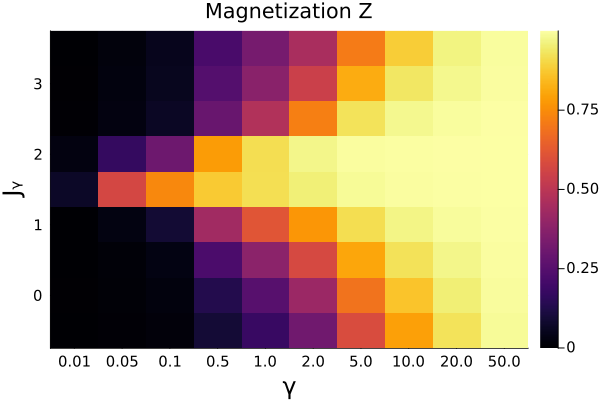

In [4]:
gammas_dummy = [i for i in 1:length(gammas)]
custom_gamma_labels = ["$gamma" for gamma in gammas]

heatmap_plot = heatmap(
    gammas_dummy,
    Jy_list,
    transpose(Mz_plateau),
    xlabel="γ",
    ylabel="Jᵧ",
    title="Magnetization Z",
    xticks=(gammas_dummy, custom_gamma_labels), 
    tickfontsize=10,
    xlabelfontsize=16,      # Size of the x-axis label
    ylabelfontsize=16,      # Size of the y-axis label
)


display(heatmap_plot)

# savefig("plots/Mz_$Jx-$Jz-plateau.pdf")

### Area/Volume law of entanglement entropy

In [5]:
function get_available_N(gamma)
    available_N = []

    if gamma == 0.1
        available_N = [10]
    elseif gamma == 0.3
        available_N = [10, 20]
    elseif gamma == 0.5
        available_N = [10, 20]
    elseif gamma == 1.0
        available_N = [10, 20]
    elseif gamma == 1.5
        available_N = [10, 20, 30]
    elseif gamma == 2.0
        available_N = [10, 20, 30, 40, 50]
    elseif gamma == 5.0
        available_N = [10, 20, 30, 40, 50]
    elseif gamma == 10.0
        available_N = [10, 20, 30, 40, 50]
    elseif gamma == 15.0
        available_N = [30, 40, 50]
    elseif gamma == 20.0
        available_N = [10, 20, 30, 40, 50]
    elseif gamma == 35.0
        available_N = [10, 20, 30, 40, 50]
    elseif gamma == 50.0
        available_N = [10, 20, 30, 50]
    else
        println("Gamma value not recognized.")
    end

    return available_N
end

get_available_N (generic function with 1 method)

In [6]:
t_list = 0:0.01:20
gamma = 1.5
ntraj=100

N_list = get_available_N(gamma)

for N in N_list 
    folder = "data/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N$(N)_gamma$(gamma)_ntraj$(n_traj)_tf$(t_list[end])"

    #check if the folder exists
    if !isdir(folder)
        println(folder)
    end
    z_ = []
    ee_ = []
    bond_dim_ = []

    for i in 1:n_traj
        if !isfile("$folder/ee_list_traj$(i).npz")
            #println("$folder/ee_list_traj$(i).npz")
        else 
            #print("$folder/ee_list_traj$(i).npz")
            try 
                data = npzread("$folder/ee_list_traj$(i).npz")
                ee_ = push!(ee_, data)
            catch e
                println("An error occurred: $e")
            end
        end
        if !isfile("$folder/bond_dim_traj$(i).npz")
            #println("$folder/bond_dim_traj$(i).npz")
        else 
            try 
                data = npzread("$folder/bond_dim_traj$(i).npz")
                bond_dim_ = push!(bond_dim_, data)
            catch e
                println("An error occurred: $e")
            end
        end
        if !isfile("$folder/z_list_traj$(i).npz")
            #println("$folder/z_list_traj$(i).npz")
        else 
            #print("$folder/z_list_traj$(i).npz")
            try 
                data = npzread("$folder/z_list_traj$(i).npz")
                z_ = push!(z_, data)
            catch e
                println("An error occurred: $e")
            end
        end
    end
   #println("we have data for N = $N, gamma = $gamma: ")
    ee_ = hcat(ee_...)
    z_ = hcat(z_...)
    bond_dim_ = hcat(bond_dim_...)
    #print("gamma = $gamma: ", size(mean(ee_, dims=2)[:]), '\n')
    #print(mean(mean(ee_, dims=2)[:][end-100:end]), '\n')
end  

In [7]:
gammas = [1.5, 2.0, 5.0, 10.0]
t_list_gammas = [0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20]
ntraj =100
S_plateau = zeros(length(gammas))
Bond_dim_plateau = zeros(length(gammas))

pS = plot(ylabel="S(∞)", xlabel="N")
pBond = plot(ylabel="Bond dimension", xlabel="N")
pZ = plot(ylabel="Magnetization Z", xlabel="N")

for (k, gamma) in enumerate(gammas)
    N_list = get_available_N(gamma)
    print("gamma = $gamma, N_list = $N_list")
    S_plateau = zeros(length(N_list))
    Mz_plateau = zeros(length(N_list))
    Bond_dim_plateau = zeros(length(N_list))


    for (j, N) in enumerate(N_list)
        folder = "data/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N$(N)_gamma$(gamma)_ntraj$(n_traj)_tf$(t_list_gammas[k][end])"
        #check if the folder exists
        if !isdir(folder)
              println(folder)
        end
        z_ = []
        ee_ = []
        bond_dim_ = []
        
        for i in 1:n_traj
            if !isfile("$folder/ee_list_traj$(i).npz")
                #println("$folder/ee_list_traj$(i).npz")
            else 
                try 
                    data = npzread("$folder/ee_list_traj$(i).npz")
                    ee_ = push!(ee_, data)
                catch e
                    println("An error occurred: $e")
                end
            end
            if !isfile("$folder/bond_dim_traj$(i).npz")
                #println("$folder/bond_dim_traj$(i).npz")
            else 
                try 
                    data = npzread("$folder/bond_dim_traj$(i).npz")
                    bond_dim_ = push!(bond_dim_, data)
                catch e
                    println("An error occurred: $e")
                end
            end
            if !isfile("$folder/z_list_traj$(i).npz")
                #println("$folder/z_list_traj$(i).npz")
            else 
                try 
                    data = npzread("$folder/z_list_traj$(i).npz")
                    z_ = push!(z_, data)
                catch e
                    println("An error occurred: $e")
                end
            end
        end
        ee_ = hcat(ee_...)
        z_ = hcat(z_...)
        bond_dim_ = hcat(bond_dim_...)
        #print("gamma = $gamma: ", size(mean(ee_, dims=2)[:]), '\n')
        #print(mean(mean(ee_, dims=2)[:][end-500:end]), '\n')
        S_plateau[j] = mean(mean(ee_, dims=2)[:][end-500:end])
        Mz_plateau[j] = mean(mean(z_, dims=2)[:][end-500:end])
        Bond_dim_plateau[j] = mean(mean(bond_dim_, dims=2)[:][end-500:end])        
    end
    plot!(pS, N_list, S_plateau, label="γ = $gamma", marker=:circle,  markersize=6, linewidth=5)
    plot!(pBond, N_list, Bond_dim_plateau, label="γ = $gamma", marker=:circle,  markersize=6, linewidth=5)
end

gamma = 1.5, N_list = [10, 20, 30]gamma = 2.0, N_list = [10, 20, 30, 40, 50]gamma = 5.0, N_list = [10, 20, 30, 40, 50]gamma = 10.0, N_list = [10, 20, 30, 40, 50]

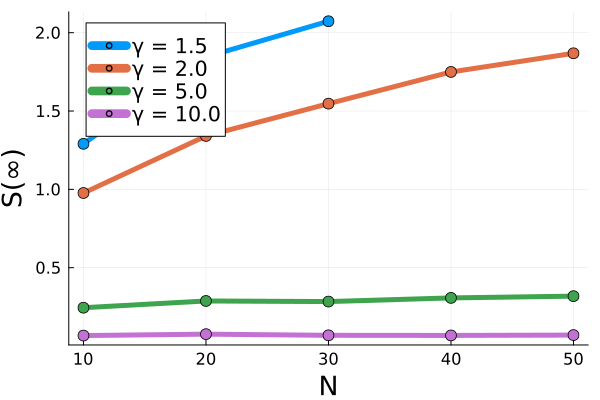

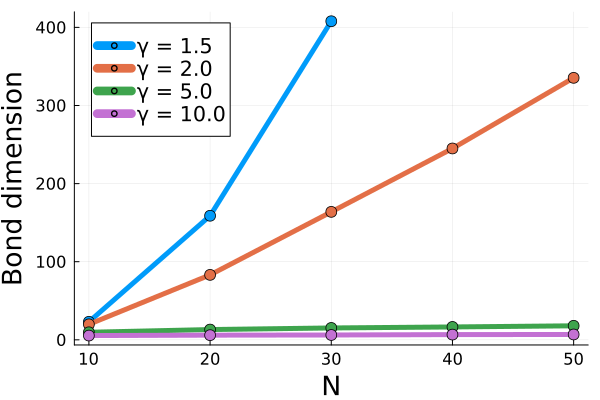

In [8]:
gr()#save figures
plot!(pS, #title="S(∞) vs N", #font of ticks and labels tickfontsize=10,
        xlabelfontsize=18,      # Size of the x-axis label
        ylabelfontsize=18, 
        legendfontsize=14, tickfontsize=11, seriestype = :line)
        
plot!(pBond, #title="Bond dimension vs N", 
        xlabelfontsize=18,      # Size of the x-axis label
        ylabelfontsize=18,
        legendfontsize=14, tickfontsize=11)

# savefig(pS, "plots/S_vs_N.pdf")
# savefig(pBond, "plots/Bond_dim_vs_N.pdf")
# savefig(pZ, "plots/Mz_vs_N.pdf")


display(pS)
display(pBond)

### S vs t to test convergence

In [9]:
N=40
t_list = 0:0.01:20.0
gamma=2.0
Jy = 2.5
Jx, Jz = 1.8, 2.0
n_traj = 100
folder = "data/XYZ_Jx$(Jx)_Jz$(Jz)_Jy$(Jy)_cl"
counter = 0
#read the data
ee_ = []
bond_dim_ = []
z_ = []
for i in 1:n_traj
    if !isfile("$folder/N$(N)_gamma$(gamma)_ntraj$(n_traj)_tf$(t_list[end])/ee_list_traj$(i).npz")
        #counter += 1
        #println("$folder/N$(N)_gamma$(gamma)_ntraj$(n_traj)_tf$(t_list[end])/ee_list_traj$(i).npz")
    else 
        #println("$folder/N$(N)_gamma$(gamma)_ntraj$(n_traj)_tf$(t_list[end])/ee_list_traj$(i).npz")
        try
            data = npzread("$folder/N$(N)_gamma$(gamma)_ntraj$(n_traj)_tf$(t_list[end])/ee_list_traj$(i).npz")
            ee_ = push!(ee_, data)
            counter += 1
        catch e
            println("An error occurred: $e")
        end
    end
    if !isfile("$folder/N$(N)_gamma$(gamma)_ntraj$(n_traj)_tf$(t_list[end])/bond_dim_traj$(i).npz")
        #println("$folder/N$(N)_gamma$(gamma)_ntraj$(n_traj)_tf$(t_list[end])/bond_dim_traj$(i).npz")
    else 
        bond_dim = npzread("$folder/N$(N)_gamma$(gamma)_ntraj$(n_traj)_tf$(t_list[end])/bond_dim_traj$(i).npz")
        bond_dim_ = push!(bond_dim_, bond_dim)
    end
    if !isfile("$folder/N$(N)_gamma$(gamma)_ntraj$(n_traj)_tf$(t_list[end])/z_list_traj$(i).npz")
        #println("$folder/N$(N)_gamma$(gamma)_ntraj$(n_traj)_tf$(t_list[end])/z_list_traj$(i).npz")
    else 
        z = npzread("$folder/N$(N)_gamma$(gamma)_ntraj$(n_traj)_tf$(t_list[end])/z_list_traj$(i).npz")
        z_ = push!(z_, z)
    end
end


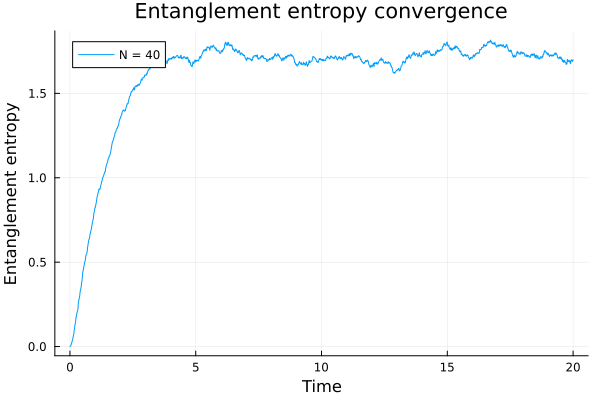

In [10]:
plot(t_list, mean(ee_, dims=1)[1], label="N = $N", xlabel="Time", ylabel="Entanglement entropy", title="Entanglement entropy convergence", legend=:topleft)

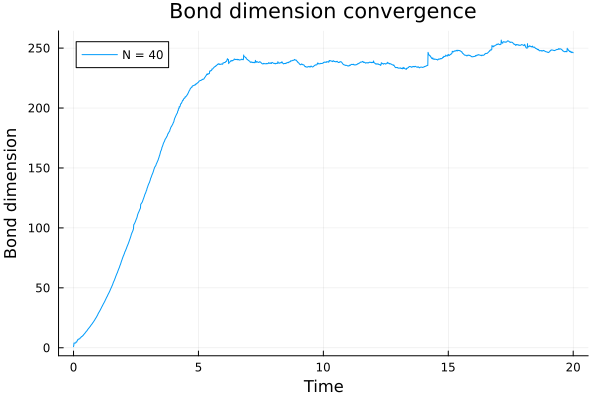

In [11]:
#bond dimension
plot(t_list, mean(bond_dim_, dims=1)[1], label="N = $N", xlabel="Time", ylabel="Bond dimension", title="Bond dimension convergence", legend=:topleft)
#plot(t_list, mean(z_, dims=1)[1], label="N = $N", xlabel="Time", ylabel="Magnetization Z", title="Magnetization Z for different N", legend=:topleft)

### Critical behavior for fixed N and varying $\gamma$

In [12]:
N_list = [10, 20, 30, 40, 50]
S_plateau = zeros(length(N_list), length(gammas))
Mz_plateau = zeros(length(N_list), length(gammas))
Bond_dim_plateau = zeros(length(N_list), length(gammas))

N=40

#gammas = [5.0, 10.0, 15.0, 20.0, 35.0]
n_traj=100
Jx, Jy, Jz = 1.8, 2.5, 2.0
#t_list_gammas = [0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:10]

if N==10
    print("N = $N\n")
    gammas = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 35.0, 50.0]
    t_list_gammas = [0:0.01:40, 0:0.01:30, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:10, 0:0.01:10]
elseif N==20
    gammas = [0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 35.0, 50.0]
    t_list_gammas = [0:0.01:30, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:10, 0:0.01:10]
elseif N==50
    gammas = [5.0, 10.0, 15.0, 20.0, 35.0, 50.0]
    t_list_gammas = [0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:10, 0:0.01:10]
elseif N==30
    gammas = [2.0, 5.0, 10.0, 15.0, 20.0, 35.0, 50.0]
    t_list_gammas = [0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:10, 0:0.01:10]
elseif N==40
    gammas = [2.0, 5.0, 10.0, 15.0, 20.0, 35.0]
    t_list_gammas = [0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:10]
end

for (j, gamma) in enumerate(gammas)
    println("gamma = $gamma\n")
    t_list = t_list_gammas[j]
    #read data for different gamma, take plateau values of S and Mz
    folder = "data/XYZ_Jx$(Jx)_Jz$(Jz)_Jy$(Jy)_cl/N$(N)_gamma$(gamma)_ntraj$(n_traj)_tf$(t_list[end])"
    #check if the folder exists
    if !isdir(folder)
        println(folder)
    end
    ee_ = []
    z_ = []
    bond_dim_ = []

    for i in 1:n_traj
        if !isfile("$folder/ee_list_traj$(i).npz")
            #println("$folder/ee_list_traj$(i).npz")
        else 
            #print("$folder/ee_list_traj$(i).npz")
            try 
                data = npzread("$folder/ee_list_traj$(i).npz")
                ee_ = push!(ee_, data)
            catch e
                println("An error occurred: $e")
            end
        end
        if !isfile("$folder/bond_dim_traj$(i).npz")
            #println("$folder/bond_dim_traj$(i).npz")
        else 
            #print("$folder/ee_list_traj$(i).npz")
            try 
                data = npzread("$folder/bond_dim_traj$(i).npz")
                bond_dim_ = push!(bond_dim_, data)
            catch e
                println("An error occurred: $e")
            end
        end
        if !isfile("$folder/z_list_traj$(i).npz")
           # println("$folder/z_list_traj$(i).npz")
        else 
            #print("$folder/z_list_traj$(i).npz")
            try 
                data = npzread("$folder/z_list_traj$(i).npz")
                z_ = push!(z_, data)
            catch e
                println("An error occurred: $e")
            end
        end
    end
    ee_ = hcat(ee_...)
    z_ = hcat(z_...)
    bond_dim_ = hcat(bond_dim_...)
    print(size(ee_))    
    print("gamma = $gamma: ", size(mean(ee_, dims=2)[:]), '\n')
    print(mean(mean(ee_, dims=2)[:][end-500:end]), '\n')
    S_plateau[j] = mean(mean(ee_, dims=2)[:][end-500:end])
    Bond_dim_plateau[j] = mean(mean(bond_dim_, dims=2)[:][end-500:end])
end


gamma = 2.0

(2001, 84)gamma = 2.0: (2001,)
1.7412787215193173
gamma = 5.0

(2001, 31)gamma = 5.0: (2001,)
0.29646824690419077
gamma = 10.0

(2001, 100)gamma = 10.0: (2001,)
0.07224698253313526
gamma = 15.0

(2001, 97)gamma = 15.0: (2001,)
0.03163098310349131
gamma = 20.0

(2001, 97)gamma = 20.0: (2001,)
0.02252938715165148
gamma = 35.0

(1001, 67)gamma = 35.0: (1001,)
0.00726708699558974


In [13]:
#N_list = [10, 20, 30, 40, 50]
N_list = [10, 20, 30, 40, 50]
Jx, Jy, Jz = 1.8, 2.5, 2.0
S_plateau_N = []
Mz_plateau_N = []
Bond_dim_plateau =[]


plotS  = plot(xlabel="γ", ylabel="S(∞)", xscale=:log10)
plotMz = plot(xlabel="γ", ylabel="Magnetization Mₓ ", xscale=:log10)
plotBond = plot(xlabel="γ", ylabel="Bond dimension", xscale=:log10)


for (n, N) in enumerate(N_list)
    if N==10
        print("N = $N\n")
        gammas = [0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0, 35.0, 50.0]
        t_list_gammas = [0:0.01:40, 0:0.01:30, 0:0.01:30, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:10, 0:0.01:10]
    elseif N==20
        gammas = [0.3, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0, 35.0, 50.0]
        t_list_gammas = [0:0.01:30, 0:0.01:30, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:10, 0:0.01:10]
    elseif N==50
        gammas = [2.0, 5.0, 10.0, 15.0, 20.0, 35.0, 50.0]
        t_list_gammas = [0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:10, 0:0.01:10]
    elseif N==30
        gammas = [1.5, 2.0, 5.0, 10.0, 15.0, 20.0, 35.0, 50.0]
        t_list_gammas = [0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:10, 0:0.01:10]
    elseif N==40
        gammas = [2.0, 5.0, 10.0, 15.0, 20.0, 35.0]
        t_list_gammas = [0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:20, 0:0.01:10]
    end
    
    n_traj=100
    S_plateau = zeros(length(gammas))
    Mz_plateau = zeros(length(gammas))
    Bond_dim_plateau = zeros(length(gammas))

    for (j, gamma) in enumerate(gammas)
        t_list = t_list_gammas[j]
        #read data for different gamma, take plateau values of S and Mz
        folder = "data/XYZ_Jx$(Jx)_Jz$(Jz)_Jy$(Jy)_cl_/N$(N)_gamma$(gamma)_ntraj$(n_traj)_tf$(t_list[end])"
        #check if the folder exists
        if !isdir(folder)
            println(folder)
        end
        ee_ = []
        z_ = []
        bond_dim_ = []

        for i in 1:n_traj
            if !isfile("$folder/ee_list_traj$(i).npz")
                #println("$folder/ee_list_traj$(i).npz")
            else 
                print("$folder/ee_list_traj$(i).npz")
                try 
                    data = npzread("$folder/ee_list_traj$(i).npz")
                    ee_ = push!(ee_, data)
                catch e
                    println("An error occurred: $e")
                end
            end
            if !isfile("$folder/bond_dim_traj$(i).npz")
                #println("$folder/bond_dim_traj$(i).npz")
            else 
                print("$folder/ee_list_traj$(i).npz")
                try 
                    data = npzread("$folder/bond_dim_traj$(i).npz")
                    bond_dim_ = push!(bond_dim_, data)
                catch e
                    println("An error occurred: $e")
                end
            end
            if !isfile("$folder/z_list_traj$(i).npz")
            # println("$folder/z_list_traj$(i).npz")
            else 
                print("$folder/z_list_traj$(i).npz")
                try 
                    data = npzread("$folder/z_list_traj$(i).npz")
                    z_ = push!(z_, data)
                catch e
                    println("An error occurred: $e")
                end
            end
        end
        ee_ = hcat(ee_...)
        z_ = hcat(z_...)
        bond_dim_ = hcat(bond_dim_...)
        print(size(ee_))    
        print("gamma = $gamma: ", size(mean(ee_, dims=2)[:]), '\n')
        print(mean(mean(ee_, dims=2)[:][end-100:end]), '\n')
        S_plateau[j] = mean(mean(ee_, dims=2)[:][end-500:end])
        Mz_plateau[j] = mean(mean(z_, dims=2)[:][end-500:end])
        Bond_dim_plateau[j] = mean(mean(bond_dim_, dims=2)[:][end-500:end])
        #Bond_dim_plateau[j] = maximum(bond_dim_)
    end
    plot!(plotS, gammas, S_plateau, label="N = $N", marker=:circle, markersize=5, linewidth=4)
    plot!(plotBond, gammas, Bond_dim_plateau, label="N = $N", marker=:circle, markersize=5, linewidth=4)
    plot!(plotMz, gammas, Mz_plateau, label="N = $N", marker=:circle, markersize=5, linewidth=4)
end

N = 10
data/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N10_gamma0.1_ntraj100_tf40.0/ee_list_traj1.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N10_gamma0.1_ntraj100_tf40.0/ee_list_traj1.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N10_gamma0.1_ntraj100_tf40.0/z_list_traj1.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N10_gamma0.1_ntraj100_tf40.0/ee_list_traj2.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N10_gamma0.1_ntraj100_tf40.0/ee_list_traj2.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N10_gamma0.1_ntraj100_tf40.0/z_list_traj2.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N10_gamma0.1_ntraj100_tf40.0/ee_list_traj3.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N10_gamma0.1_ntraj100_tf40.0/ee_list_traj3.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N10_gamma0.1_ntraj100_tf40.0/z_list_traj3.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N10_gamma0.1_ntraj100_tf40.0/ee_list_traj4.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N10_gamma0.1_ntraj100_tf40.0/ee_list_traj4.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N10_gamma0.1_ntraj100_tf40.0/z_list_traj4.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N10_gamma0.1_ntraj100_tf40.0/ee_list_traj5

Excessive output truncated after 524346 bytes.

(1001, 61)gamma = 50.0: (1001,)
0.005113012762802315
data/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N40_gamma2.0_ntraj100_tf20.0/ee_list_traj1.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N40_gamma2.0_ntraj100_tf20.0/ee_list_traj2.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N40_gamma2.0_ntraj100_tf20.0/ee_list_traj3.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N40_gamma2.0_ntraj100_tf20.0/ee_list_traj3.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N40_gamma2.0_ntraj100_tf20.0/ee_list_traj4.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N40_gamma2.0_ntraj100_tf20.0/z_list_traj4.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N40_gamma2.0_ntraj100_tf20.0/ee_list_traj5.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N40_gamma2.0_ntraj100_tf20.0/ee_list_traj5.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N40_gamma2.0_ntraj100_tf20.0/ee_list_traj6.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N40_gamma2.0_ntraj100_tf20.0/ee_list_traj7.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N40_gamma2.0_ntraj100_tf20.0/ee_list_traj7.npzdata/XYZ_Jx1.8_Jz2.0_Jy2.5_cl_/N40_gamma2.0_ntraj100_tf20.0/ee_list_traj8.npzdata/XYZ_Jx1.8_Jz2.0_Jy2

In [14]:
#save plotS
#change title of the plots
plot!(plotS, #title="Entanglement entropy vs γ"
       xlabelfontsize=18,      # Size of the x-axis label
        ylabelfontsize=18, 
        legendfontsize=14, tickfontsize=11)
plot!(plotMz, #title="Magnetization Z vs γ"
       xlabelfontsize=18,      # Size of the x-axis label
       ylabelfontsize=18,
       legendfontsize=14, tickfontsize=11)
plot!(plotBond, #title="Bond dimension vs γ", yscale=:log10
       xlabelfontsize=18,      # Size of the x-axis label
       ylabelfontsize=18,
       legendfontsize=14, tickfontsize=11);


# savefig(plotS, "plots/S_vs_gamma.pdf")
# savefig(plotMz,"plots/Mz_vs_gamma.pdf")
# savefig(plotBond,"plots/Bond_vs_gamma.pdf")

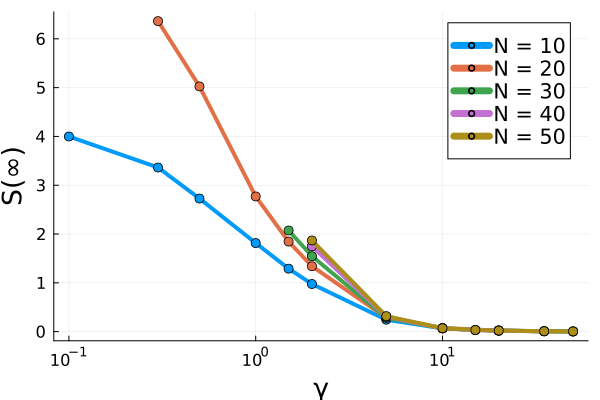

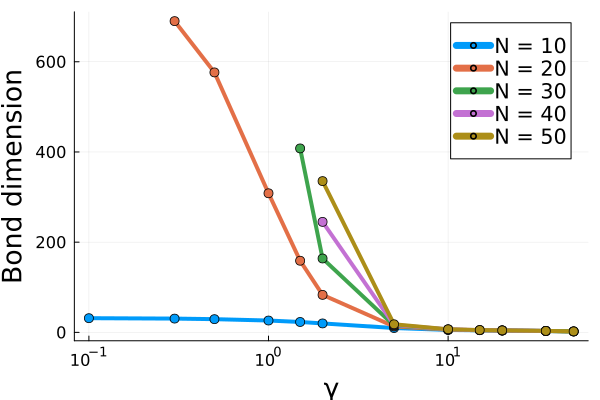

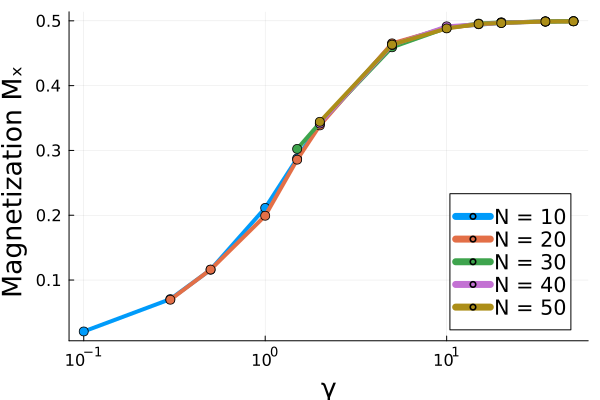

In [15]:
display(plotS)
display(plotBond)
display(plotMz)
